In [3]:
import jax.numpy as jnp
import jax
from fbpinns.problems import Problem

class Schrodinger1D(Problem):
    """
    Solves the 1D time-dependent Schrödinger equation for the harmonic oscillator:

         i ψ_t = -½ ψ_{xx} + ½ ω² x² ψ,

    where the complex wavefunction ψ is split into real and imaginary parts:
         ψ(x,t) = u(x,t) + i v(x,t).

    This leads to a coupled system of two real PDEs:
    
         - v_t + ½ u_{xx} - ½ ω² x² u = 0,   (Equation 1)
         u_t + ½ v_{xx} - ½ ω² x² v = 0.      (Equation 2)
    
    The initial condition is chosen to be the ground state of the harmonic oscillator:
    
         ψ(x,0) = ψ₀(x) = (ω/π)^(¼) exp(-ω x²/2),
    
    so that u(x,0) = ψ₀(x) and v(x,0) = 0.
    
    The spatial domain is chosen as x ∈ [-L, L] (with L sufficiently large so that ψ ≈ 0 at x = ±L)
    and time t ∈ [0, T].
    """

    @staticmethod
    def init_params(omega=1.0, L=5.0, sd=0.1):
        # Define the dimensionality:
        #   ud = 2 (u, v)
        #   xd = 2 (x, t)
        static_params = {
            "dims": (2, 2),
            "omega": omega,
            "L": L,
            "sd": sd
        }
        return static_params, {}

    @staticmethod
    def sample_constraints(all_params, domain, key, sampler, batch_shapes):
        x_batch = domain.sample_interior(all_params, key, sampler, batch_shapes[0])
        
        # For the two equations, we need the following derivatives:
        # For Equation (1): we require u, u_{xx} and v_t.
        # For Equation (2): we require v, v_{xx} and u_t.
        required_diffs = (
            (0, ()),     # u
            (0, (0, 0)), # u_xx
            (1, (1,)),   # v_t
            (1, ()),     # v
            (1, (0, 0)), # v_xx
            (0, (1,)),   # u_t
        )
        return [[x_batch, required_diffs],]

    @staticmethod
    def constraining_fn(all_params, x_batch, net_out):
        """
        Enforces both the initial condition and the boundary conditions by reparameterizing
        the network output.
        
        Let the raw network output be:
             N(x,t) = [N_u(x,t), N_v(x,t)].
        
        We define the full solution as:
        
            u(x,t) = A(x) * t * N_u(x,t) + ψ₀(x),
            v(x,t) = A(x) * t * N_v(x,t),
        
        where:
          - A(x) = (L² - x²)/L² is a spatial multiplier that vanishes at the boundaries x = ±L,
          - ψ₀(x) = (ω/π)^(¼) exp(-ω x²/2) is the initial wavefunction.
        
        In this way, at t = 0 the network’s contribution vanishes, ensuring that
        u(x,0) = ψ₀(x) and v(x,0) = 0, and the boundary conditions are automatically satisfied.
        """

        x = x_batch[:, 0:1]
        t = x_batch[:, 1:2]
        omega = all_params["static"]["problem"]["omega"]
        L = all_params["static"]["problem"]["L"]
        sd = all_params["static"]["problem"]["sd"]
        tanh = jax.nn.tanh
        
        # Constraining function
        c = tanh((L+x)/sd) * tanh((L-x)/sd)
        
        # Define the initial condition (ground state of the harmonic oscillator)
        psi0 = (omega / jnp.pi)**0.25 * jnp.exp(-omega * x**2 / 2.0)
        
        # Split the raw network output into its two components.
        u = net_out[:, 0:1]
        v = net_out[:, 1:2]
        
        # Reparameterize to enforce the conditions.
        u = c * t * u + psi0
        v = c * t * v
        # Concatenate u and v to form the full two-component output.
        return jnp.concatenate([u, v], axis=1)

    @staticmethod
    def loss_fn(all_params, constraints):
        """
        Computes the physics residual for both equations:
        
        Equation (1): -v_t + ½ u_{xx} - ½ ω² x² u = 0.
        Equation (2):  u_t + ½ v_{xx} - ½ ω² x² v = 0.
        
        The loss is defined as the sum of the mean squared errors of the residuals for
        both equations.
        """
        omega = all_params["static"]["problem"]["omega"]
        x_batch, u, uxx, vt, v, vxx, ut = constraints[0]
        
        x = x_batch[:, 0:1]
        
        res1 = -vt + 0.5 * uxx - 0.5 * omega**2 * (x**2) * u
        res2 = ut + 0.5 * vxx - 0.5 * omega**2 * (x**2) * v
        
        loss1 = jnp.mean(res1**2)
        loss2 = jnp.mean(res2**2)
        return loss1 + loss2, res1 + res2

    @staticmethod
    def exact_solution(all_params, x_batch, batch_shape=None):
        """
        Returns the exact ground-state solution for the harmonic oscillator.
        
        The analytical solution (up to a global phase) is given by:
            u(x,t) = ψ₀(x) cos(ω t/2),
            v(x,t) = -ψ₀(x) sin(ω t/2),
        where ψ₀(x) = (ω/π)^(¼) exp(-ω x²/2).
        """
        omega = all_params["static"]["problem"]["omega"]
        x = x_batch[:, 0:1]
        t = x_batch[:, 1:2]
        psi0 = (omega / jnp.pi)**0.25 * jnp.exp(-omega * x**2 / 2.0)
        u = psi0 * jnp.cos(omega * t / 2.0)
        v = -psi0 * jnp.sin(omega * t / 2.0)
        return jnp.concatenate([u, v], axis=1)


[Errno 16] Device or resource busy: 'results/summaries/test/.nfs00000000624863b7000000b5'
[Errno 16] Device or resource busy: 'results/summaries/test/.nfs0000000062487000000000b8'
[Errno 16] Device or resource busy: 'results/summaries/test/.nfs0000000062486970000000b4'
[Errno 16] Device or resource busy: 'results/summaries/test/.nfs00000000624860e5000000b9'
[Errno 16] Device or resource busy: 'results/summaries/test/.nfs000000006248664b000000b7'
[Errno 16] Device or resource busy: 'results/summaries/test/.nfs0000000062486a40000000b3'
[Errno 16] Device or resource busy: 'results/summaries/test/.nfs0000000062486c32000000b6'
[INFO] 2025-05-12 00:49:08 - <fbpinns.constants.Constants object at 0x78e20f38e780>
run: test
domain: <class 'fbpinns.domains.RectangularDomainND'>
domain_init_kwargs: {'xmin': array([-5.,  0.]), 'xmax': array([5.        , 3.14159265])}
problem: <class '__main__.Schrodinger1D'>
problem_init_kwargs: {}
decomposition: <class 'fbpinns.decompositions.RectangularDecomposit

[INFO] 2025-05-12 00:49:08 - Total number of subdomains: 100
[INFO] 2025-05-12 00:49:08 - Total number of trainable parameters:
[INFO] 2025-05-12 00:49:08 - 	attention: 10,000
[INFO] 2025-05-12 00:49:08 - 	problem: 1
[INFO] 2025-05-12 00:49:08 - 	network: 4,400
[INFO] 2025-05-12 00:49:08 - Total number of constraints: 1
[INFO] 2025-05-12 00:49:08 - Computing exact solution..
[INFO] 2025-05-12 00:49:08 - Computing done
[INFO] 2025-05-12 00:49:08 - Getting test data inputs..
[INFO] 2025-05-12 00:49:08 - [i: 0/20000] Updating active inputs..
[INFO] 2025-05-12 00:49:08 - [i: 0/20000] Average number of points/dimension in active subdomains: 27.64
[INFO] 2025-05-12 00:49:08 - [i: 0/20000] Updating active inputs done (0.04 s)
[INFO] 2025-05-12 00:49:08 - [i: 0/20000] Compiling update step..
[INFO] 2025-05-12 00:49:08 - x_batch
[INFO] 2025-05-12 00:49:08 - (10000, 2), float32, JVPTracer
[INFO] 2025-05-12 00:49:08 - x_take
[INFO] 2025-05-12 00:49:08 - (76380, 2), float32, JVPTracer
[INFO] 2025-

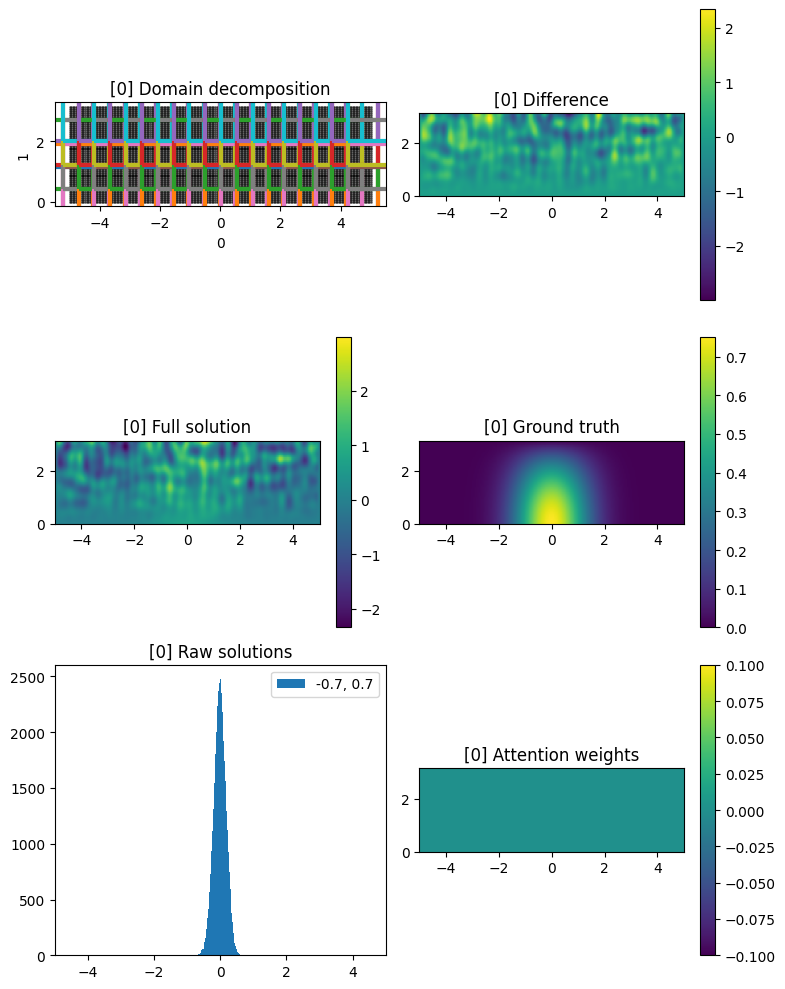

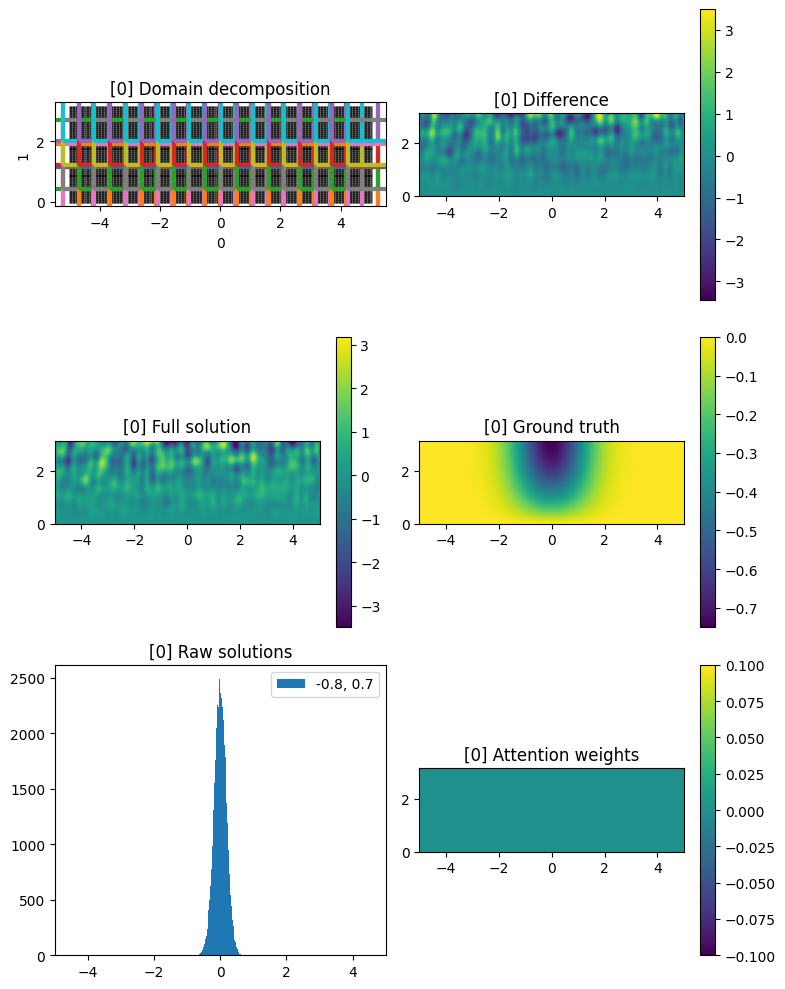

[INFO] 2025-05-12 00:49:13 - [i: 1000/20000] loss: 0.2849 rate: 307.7 elapsed: 0.00 hr test
[INFO] 2025-05-12 00:49:14 - [i: 2000/20000] loss: 0.0707 rate: 1013.9 elapsed: 0.00 hr test
[INFO] 2025-05-12 00:49:15 - [i: 3000/20000] loss: 0.0265 rate: 1020.3 elapsed: 0.00 hr test
[INFO] 2025-05-12 00:49:16 - [i: 4000/20000] loss: 0.0129 rate: 1011.6 elapsed: 0.00 hr test
[INFO] 2025-05-12 00:49:17 - [i: 5000/20000] loss: 0.0078 rate: 1018.7 elapsed: 0.00 hr test
[INFO] 2025-05-12 00:49:17 - saved arrays
[INFO] 2025-05-12 00:49:17 - saved arrays
True


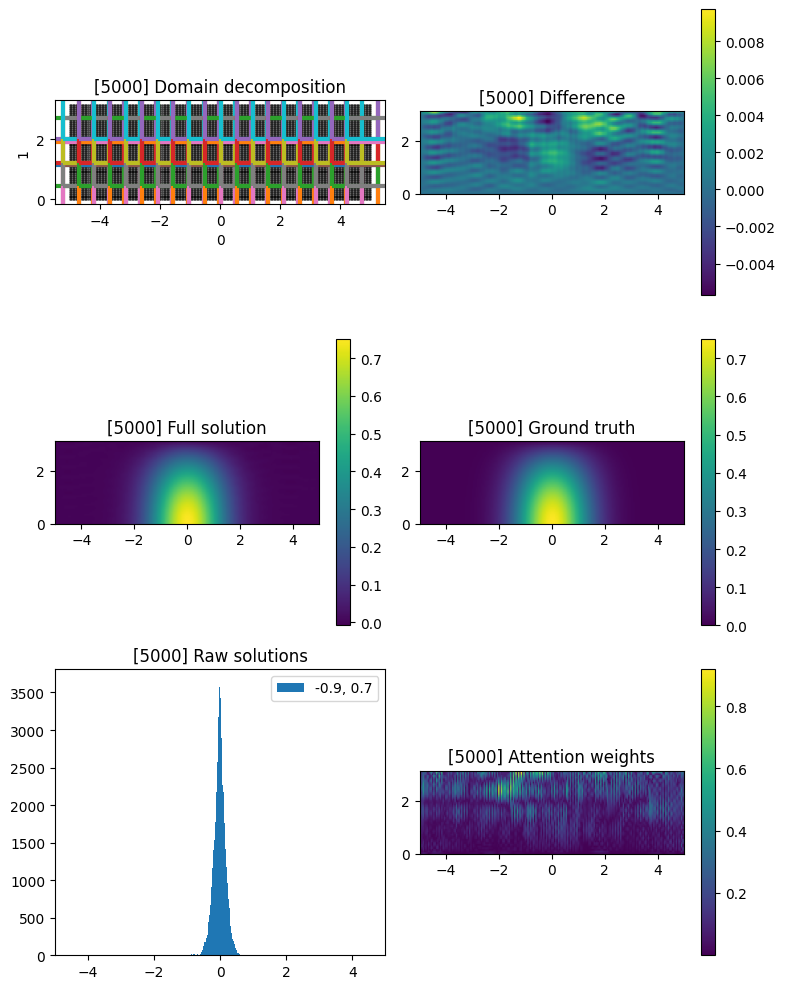

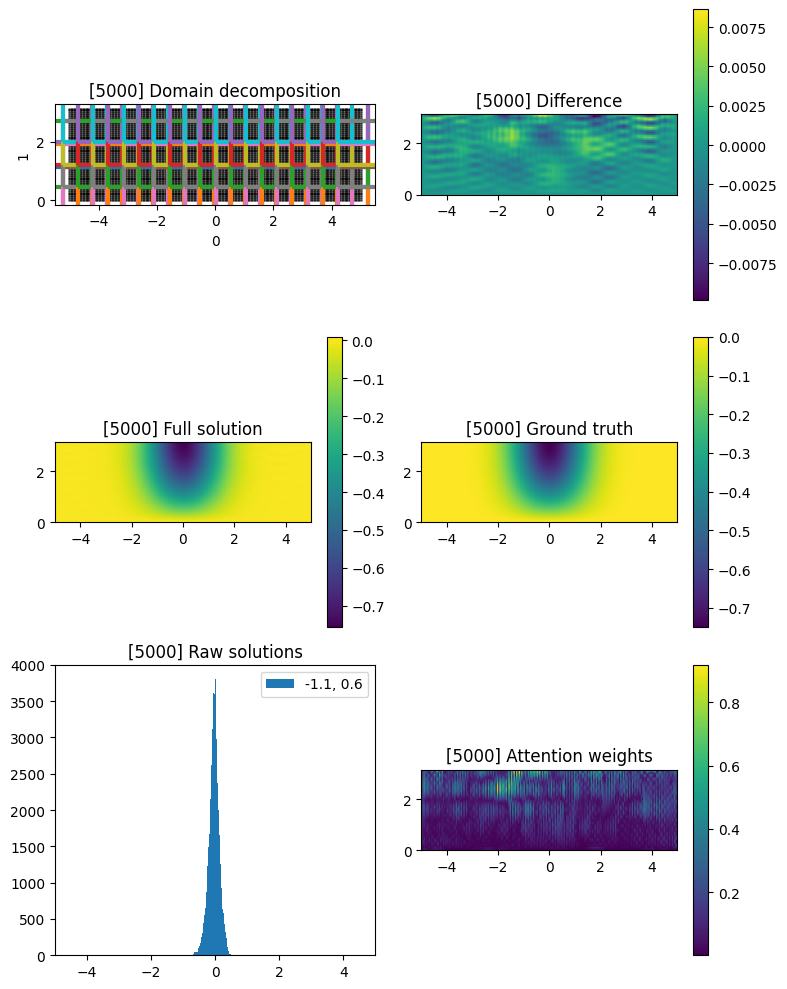

[INFO] 2025-05-12 00:49:19 - [i: 6000/20000] loss: 0.0060 rate: 1017.9 elapsed: 0.00 hr test
[INFO] 2025-05-12 00:49:20 - [i: 7000/20000] loss: 0.0051 rate: 1025.6 elapsed: 0.00 hr test
[INFO] 2025-05-12 00:49:21 - [i: 8000/20000] loss: 0.0059 rate: 1021.4 elapsed: 0.00 hr test
[INFO] 2025-05-12 00:49:22 - [i: 9000/20000] loss: 0.0056 rate: 1023.7 elapsed: 0.00 hr test
[INFO] 2025-05-12 00:49:23 - [i: 10000/20000] loss: 0.0050 rate: 1024.1 elapsed: 0.00 hr test
[INFO] 2025-05-12 00:49:23 - saved arrays
[INFO] 2025-05-12 00:49:24 - saved arrays
True


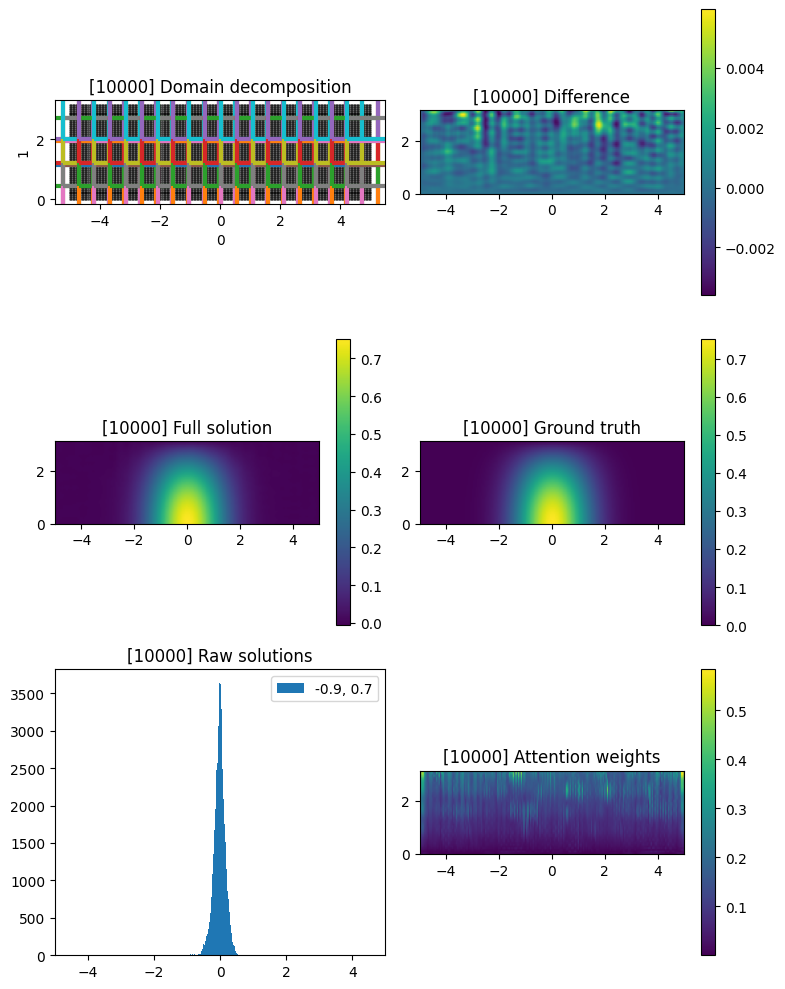

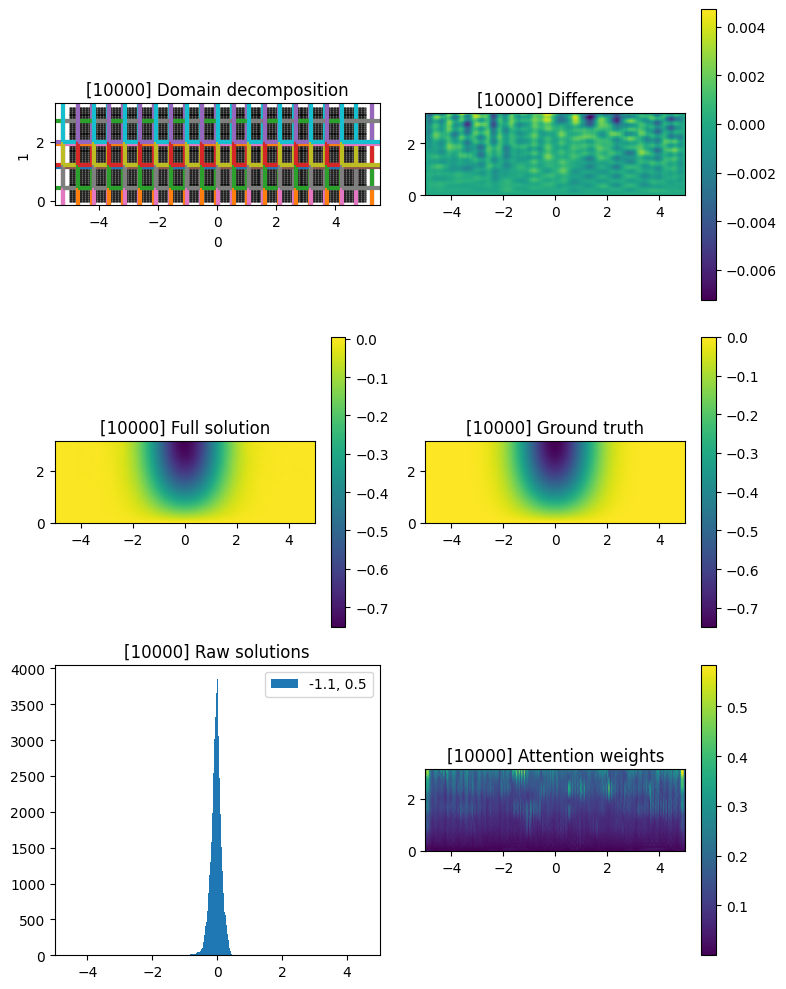

[INFO] 2025-05-12 00:49:25 - [i: 11000/20000] loss: 0.0071 rate: 1024.0 elapsed: 0.00 hr test
[INFO] 2025-05-12 00:49:26 - [i: 12000/20000] loss: 0.0054 rate: 1020.5 elapsed: 0.01 hr test
[INFO] 2025-05-12 00:49:27 - [i: 13000/20000] loss: 0.0055 rate: 1024.3 elapsed: 0.01 hr test
[INFO] 2025-05-12 00:49:28 - [i: 14000/20000] loss: 0.0030 rate: 1020.1 elapsed: 0.01 hr test
[INFO] 2025-05-12 00:49:29 - [i: 15000/20000] loss: 0.0046 rate: 1022.2 elapsed: 0.01 hr test
[INFO] 2025-05-12 00:49:30 - saved arrays
[INFO] 2025-05-12 00:49:30 - saved arrays
True


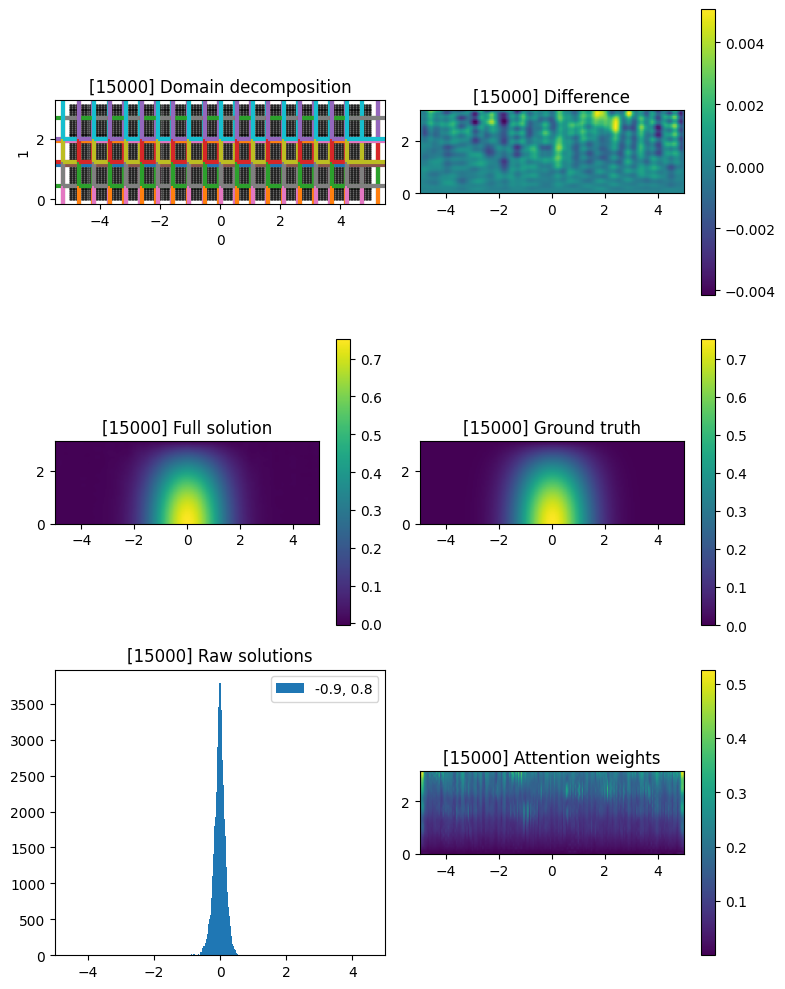

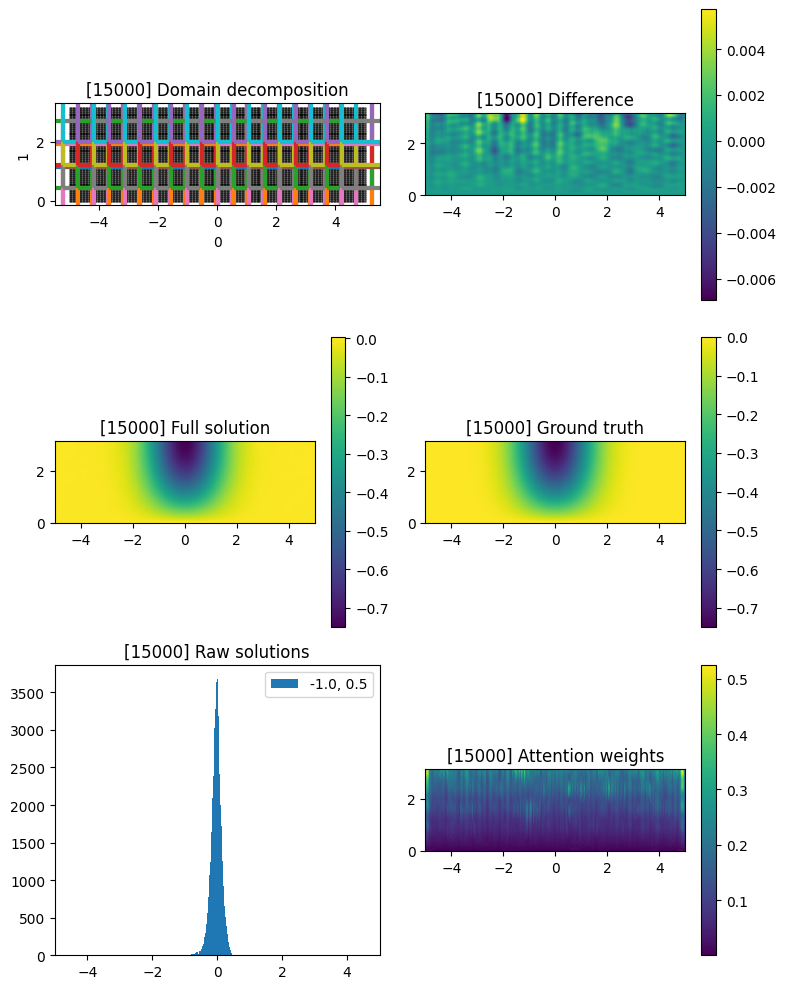

[INFO] 2025-05-12 00:49:32 - [i: 16000/20000] loss: 0.0044 rate: 1029.2 elapsed: 0.01 hr test
[INFO] 2025-05-12 00:49:33 - [i: 17000/20000] loss: 0.0040 rate: 1029.4 elapsed: 0.01 hr test
[INFO] 2025-05-12 00:49:34 - [i: 18000/20000] loss: 0.0044 rate: 1029.5 elapsed: 0.01 hr test
[INFO] 2025-05-12 00:49:35 - [i: 19000/20000] loss: 0.0046 rate: 1020.3 elapsed: 0.01 hr test
[INFO] 2025-05-12 00:49:36 - [i: 20000/20000] loss: 0.0037 rate: 1027.2 elapsed: 0.01 hr test
[INFO] 2025-05-12 00:49:36 - saved arrays
[INFO] 2025-05-12 00:49:36 - saved arrays
True


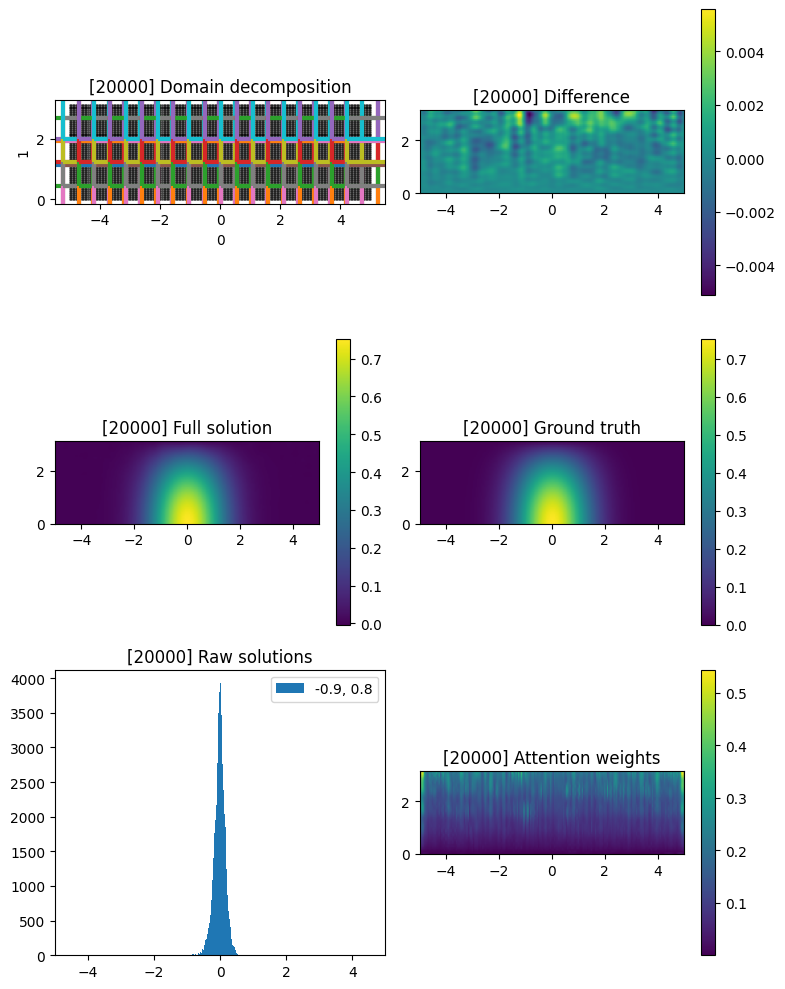

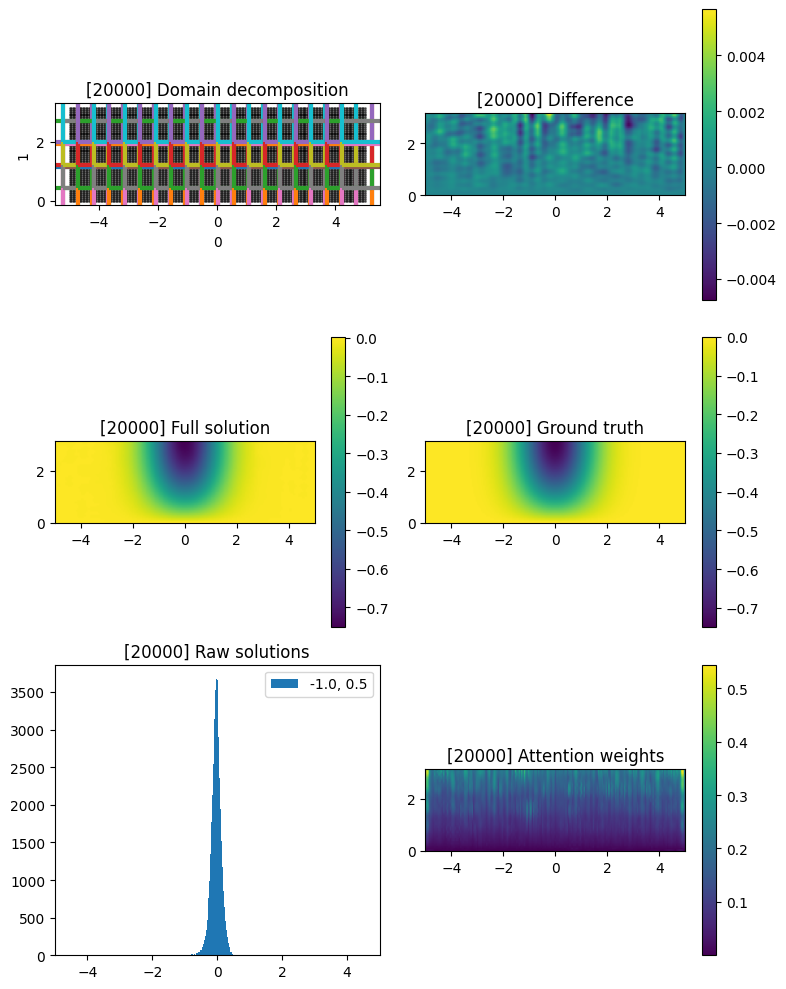

[INFO] 2025-05-12 00:49:37 - [i: 20000/20000] Training complete
[INFO] 2025-05-12 00:49:37 - [i: 20000/20000] Total training time: 29.05 s


In [8]:
import numpy as np

from fbpinns.domains import RectangularDomainND
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import FCN, ChebyshevKAN
from fbpinns.schedulers import LineSchedulerRectangularND
from fbpinns.constants import Constants, get_subdomain_ws
from fbpinns.trainers import FBPINNTrainer

x_min, x_max = -5., 5.
t_min, t_max = 0., jnp.pi
subdomain_xs=[np.linspace(x_min, x_max, 20), np.linspace(t_min, t_max, 5)]
c = Constants(
    domain=RectangularDomainND,
    domain_init_kwargs = dict(
        xmin=np.array([x_min,t_min]),
        xmax=np.array([x_max,t_max])
        ),
    problem=Schrodinger1D,
    problem_init_kwargs = dict(
    ),
    decomposition=RectangularDecompositionND,
    decomposition_init_kwargs=dict(
        subdomain_xs=subdomain_xs,
        subdomain_ws=get_subdomain_ws(subdomain_xs, 2.9),
        unnorm=(0.,3.),
    ),
    # network=FCN,
    # network_init_kwargs = dict(
    #     layer_sizes = (2, 8, 2),
    # ),
    network=ChebyshevKAN,# place a fully-connected network in each subdomain
    network_init_kwargs=dict(
        input_dim=2,
        output_dim=2,
        degree=10
    ),
    # scheduler = LineSchedulerRectangularND,
    # scheduler_kwargs = dict(
    #     point=[0.], iaxis=0,
    # ),
    optimiser_kwargs = dict(
        learning_rate=0.001
        ),
    ns=((200,50),),
    n_test=(200,50),
    n_steps=20000,
    clear_output=False,
)

run = FBPINNTrainer(c)
all_params = run.train()